In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout  # Importar Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer  # Importar TfidfVectorizer
from sklearn.utils import class_weight  # Importar class_weight
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TFBertModel
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE


In [2]:
# para mejor visualización
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

In [5]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['administracion'], random_state=81418)
X = train_df['textos']
y = train_df['administracion']

# extraccion con transformers

In [6]:
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Verifica si hay valores nulos
print("Valores nulos en el DataFrame:")
print(df.isnull().sum())

df['administracion'] = df['administracion'].astype(int)
df.rename(columns={'administracion': 'label'}, inplace=True)

# Dividir los datos en TRAIN y TEST
train_df, test_df = train_test_split(df, test_size=0.3, random_state=81418, stratify=df['label'])

def preprocess_text(text):
    return text.lower()

train_df['textos'] = train_df['textos'].apply(preprocess_text)
test_df['textos'] = test_df['textos'].apply(preprocess_text)

# Convertir los DataFrames a Datasets de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Cargar el tokenizer y el modelo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['label'].unique()))

# Tokenizar los datos
def tokenize_function(examples):
    return tokenizer(
        examples['textos'], 
        padding = 'max_length', 
        truncation = True, 
        max_length = 512
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Definir los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir = './results',
    evaluation_strategy = 'epoch',  # Evaluar al final de cada época
    save_strategy = 'epoch',  # Guardar al final de cada época
    learning_rate = 3e-5,  
    per_device_train_batch_size = 32,  
    per_device_eval_batch_size = 32,
    num_train_epochs = 4,  
    weight_decay = 0.01,
    save_total_limit = 2,  # Limitar el número de modelos guardados
    load_best_model_at_end = True,  # Cargar el mejor modelo al final
    metric_for_best_model = "eval_loss",  # Métrica para determinar el mejor modelo
)

# Definir el data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Definir el entrenador
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_test,
    tokenizer = tokenizer,
    data_collator = data_collator,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
evaluation_results = trainer.evaluate()

# Imprimir las métricas de evaluación
print("Resultados de la evaluación:")
for key, value in evaluation_results.items():
    print(f"{key}: {value:.4f}")

# Generar predicciones para el conjunto de prueba
predictions = trainer.predict(tokenized_test)

# Obtener las etiquetas predichas
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Acceder a las etiquetas verdaderas correctamente
true_labels = predictions.label_ids

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(true_labels, pred_labels, target_names=[str(i) for i in df['label'].unique()]))

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Valores nulos en el DataFrame:
textos            0
administracion    0
dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

KeyboardInterrupt: 

# Extracciòn diferentes modelos


Clasificador: Naive Bayes
Accuracy: 0.375
Recall: 0.39015151515151514
Confusion Matrix:
 [[4 4 3 0 0 0]
 [1 8 2 0 0 0]
 [2 2 2 1 1 0]
 [0 0 0 1 0 0]
 [2 0 1 1 0 0]
 [3 0 0 2 0 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.36      0.35        11
           1       0.57      0.73      0.64        11
           2       0.25      0.25      0.25         8
           3       0.20      1.00      0.33         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         5

    accuracy                           0.38        40
   macro avg       0.23      0.39      0.26        40
weighted avg       0.30      0.38      0.33        40


Clasificador: Logistic Regression
Accuracy: 0.4
Recall: 0.25946969696969696
Confusion Matrix:
 [[4 3 4 0 0 0]
 [1 9 1 0 0 0]
 [2 2 3 1 0 0]
 [0 0 1 0 0 0]
 [2 0 1 1 0 0]
 [3 0 0 2 0 0]]
Classification Report:
               precision    recall  f1-sco

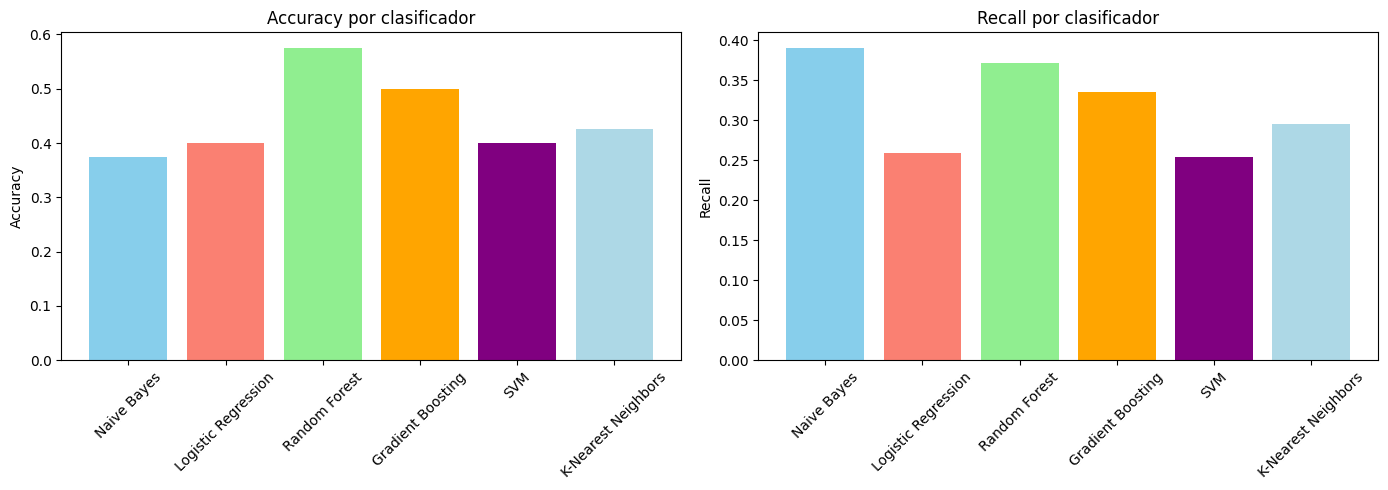

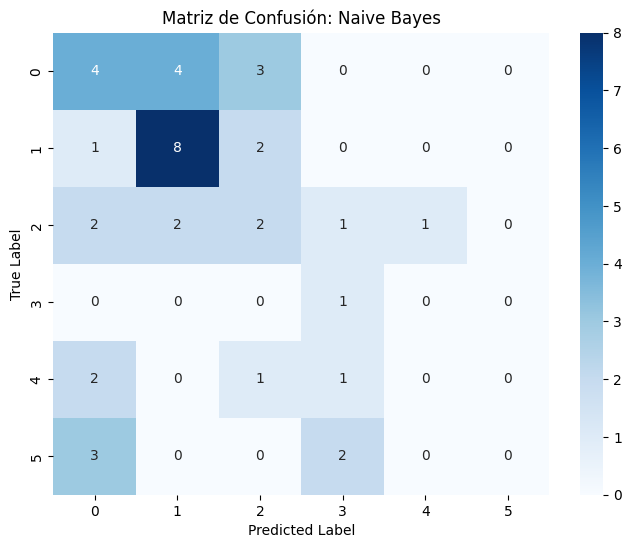

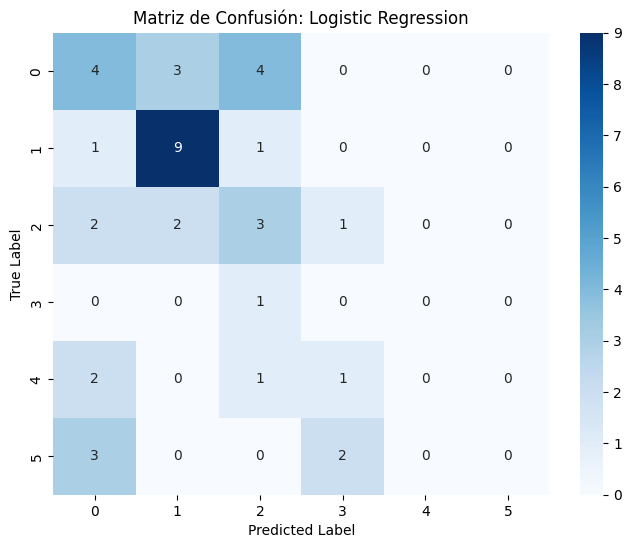

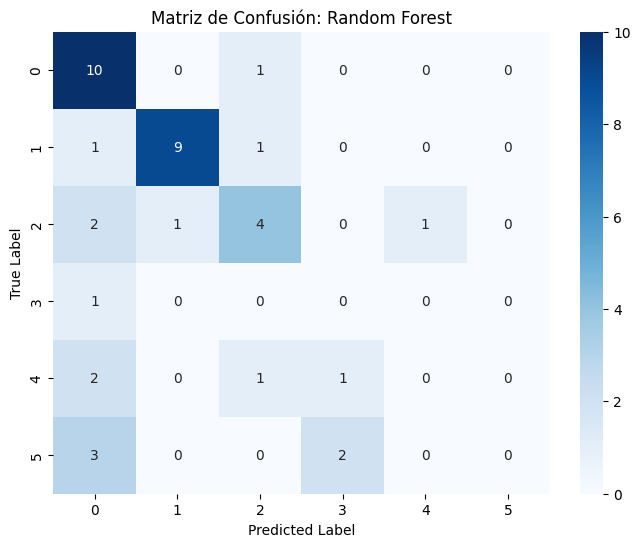

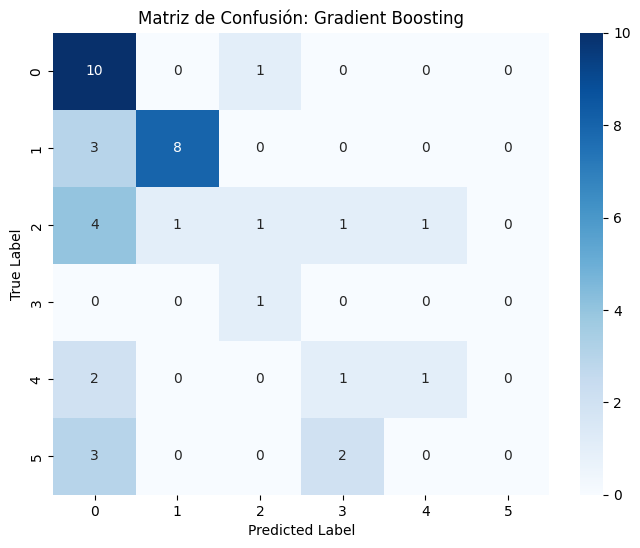

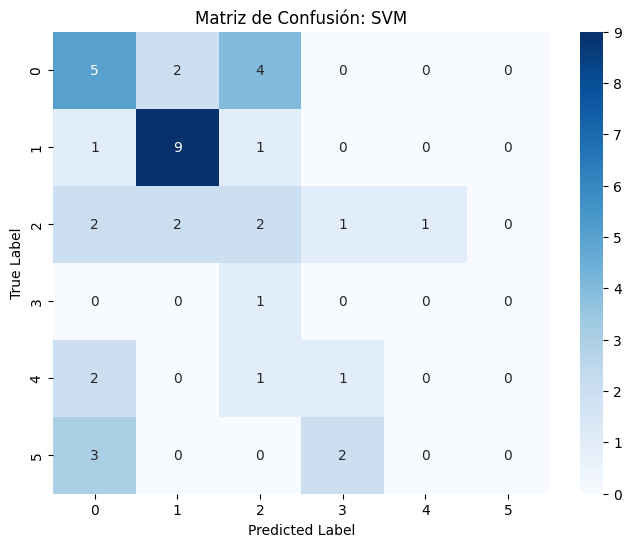

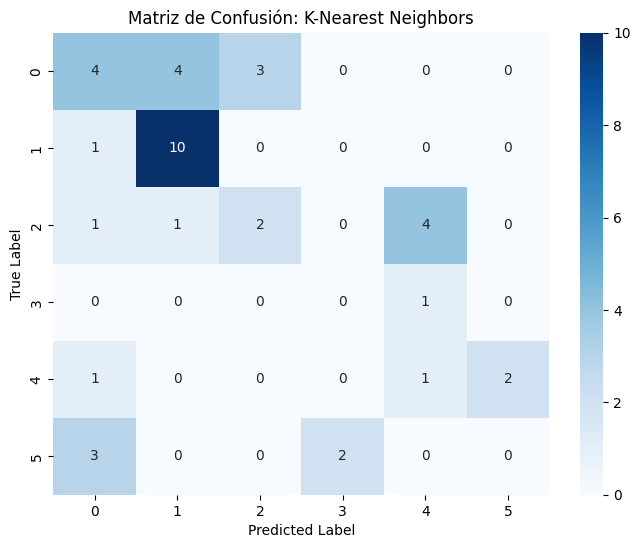

In [6]:
# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

df.dropna(inplace=True)
df['label'] = df['administracion'].astype(int)

X = df['textos']  
y = df['label']

# División de los datos en conjuntos de TRAIN y TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorización de los textos usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Definir clasificadores con hiperparámetros
classifiers = {
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "Logistic Regression": LogisticRegression(max_iter=300, C=1.5),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "SVM": SVC(C=1.0, kernel='linear', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
}

# Entrenar y evaluar cada clasificador
results = {}
for name, clf in classifiers.items():
    # Entrenamiento
    clf.fit(X_train_tfidf, y_train)
    
    # Predicción
    y_pred = clf.predict(X_test_tfidf)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')  # 'macro' para varias clases
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(6)])
    
    # Guardar resultados
    results[name] = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Confusion Matrix": conf_matrix,
        "Classification Report": report
    }
    
    # Imprimir resultados
    print(f"\nClasificador: {name}")
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)

# plot accuracy y recall
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(results.keys(), [results[clf]["Accuracy"] for clf in results], color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'lightblue'])
plt.title('Accuracy por clasificador')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(results.keys(), [results[clf]["Recall"] for clf in results], color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'lightblue'])
plt.title('Recall por clasificador')
plt.ylabel('Recall')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot Confusion Matrices
for name, clf in classifiers.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[name]["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", 
                xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
    plt.title(f"Matriz de Confusión: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# GradientBoostingClassifier modelo

Fitting 3 folds for each of 400 candidates, totalling 1200 fits

Mejores hiperparámetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}

Resultados del mejor modelo:
Accuracy: 0.6
Recall: 0.5062308549150655
Confusion Matrix:
 [[13  2  2  0  2  0]
 [ 3 13  1  0  1  0]
 [ 3  0 10  0  0  2]
 [ 1  0  0  4  0  2]
 [ 0  2  3  0  1  1]
 [ 2  1  0  0  0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63        19
           1       0.72      0.72      0.72        18
           2       0.62      0.67      0.65        15
           3       1.00      0.57      0.73         7
           4       0.25      0.14      0.18         7
           5       0.17      0.25      0.20         4

    accuracy                           0.60        70
   macro avg       0.56      0.51      0.52        70
weighted avg       0.61      0.60      0.60        70



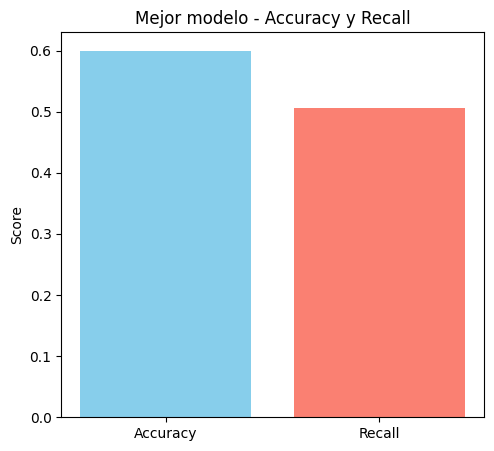

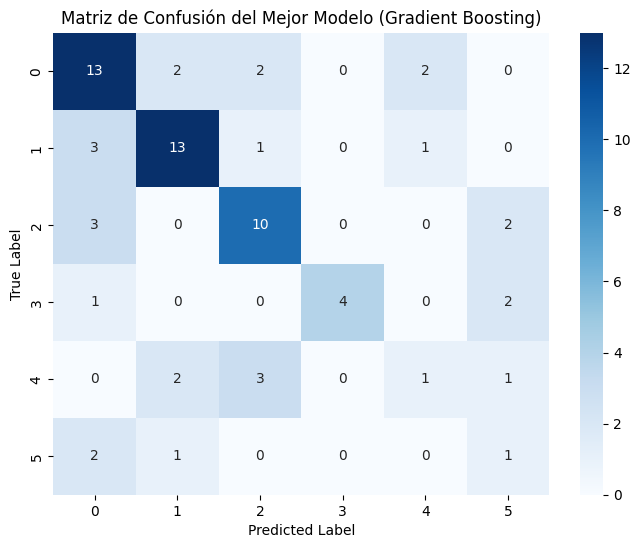

In [7]:
# Cargar el CSV
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')


df.dropna(inplace=True)
df['label'] = df['administracion'].astype(int)

X = df['textos'] 
y = df['label']

random = 81418

# División de los datos en conjuntos de TRAIN y TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=random)

# Vectorización de los textos usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Definir la cuadrícula de hiperparámetros para Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300, 50],                    # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1, 0.5],                # Tasa de aprendizaje
    'max_depth': [2, 3, 5, 7, 11],                          # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10, 15, 17]                 # Mínimo de muestras para dividir un nodo
    }

# Configuración con GridSearchCV
gb = GradientBoostingClassifier(random_state=random)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Mejor modelo
best_gb = grid_search.best_estimator_
print(f"\nMejores hiperparámetros encontrados: {grid_search.best_params_}")

# Evaluación en el conjunto de prueba
y_pred = best_gb.predict(X_test_tfidf)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # 'macro' para varias clases
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(6)])

# Mostrar resultados
print("\nResultados del mejor modelo:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# Visualización de resultados
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(['Accuracy', 'Recall'], [accuracy, recall], color=['skyblue', 'salmon'])
plt.title('Mejor modelo - Accuracy y Recall')
plt.ylabel('Score')

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Mejor Modelo (Gradient Boosting)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# RandomForest

Fitting 3 folds for each of 288 candidates, totalling 864 fits

Mejores hiperparámetros encontrados: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Resultados del mejor modelo:
Accuracy: 0.6571428571428571
Recall: 0.530959342801448
Confusion Matrix:
 [[16  2  1  0  0  0]
 [ 4 13  1  0  0  0]
 [ 2  0 12  0  0  1]
 [ 1  0  1  4  0  1]
 [ 0  2  3  0  0  2]
 [ 1  1  0  1  0  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.84      0.74        19
           1       0.72      0.72      0.72        18
           2       0.67      0.80      0.73        15
           3       0.80      0.57      0.67         7
           4       0.00      0.00      0.00         7
           5       0.20      0.25      0.22         4

    accuracy                           0.66        70
   macro avg       0.51      0.53      0.51        70
weighted avg       0.60      0.66      0.62     

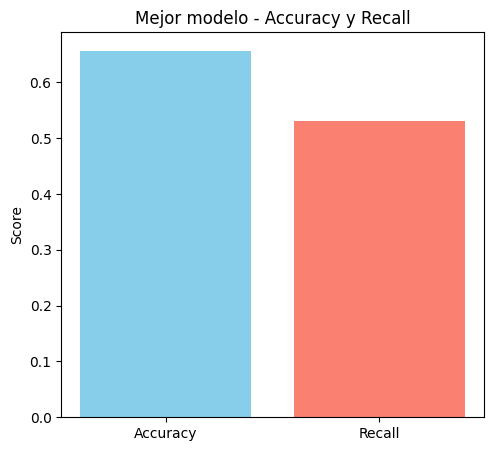

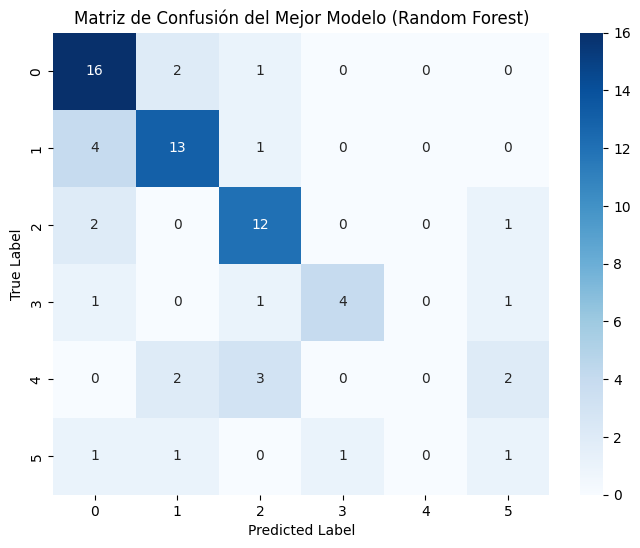

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el CSV
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Limpieza de datos
df.dropna(inplace=True)
df['label'] = df['administracion'].astype(int)

X = df['textos']
y = df['label']

random = 81418

# División de los datos en conjuntos de TRAIN y TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=random)

# Vectorización de los textos usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Definir la cuadrícula de hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 50],                   # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30],                       # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],                       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],                         # Mínimo de muestras en una hoja
    'bootstrap': [True, False]                             # Método de muestreo (con o sin reemplazo)
}

# Configuración con GridSearchCV
rf = RandomForestClassifier(random_state=random)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Mejor modelo
best_rf = grid_search.best_estimator_
print(f"\nMejores hiperparámetros encontrados: {grid_search.best_params_}")

# Evaluación en el conjunto de prueba
y_pred = best_rf.predict(X_test_tfidf)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # 'macro' para varias clases
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(6)])

# Mostrar resultados
print("\nResultados del mejor modelo:")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# Visualización de resultados
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(['Accuracy', 'Recall'], [accuracy, recall], color=['skyblue', 'salmon'])
plt.title('Mejor modelo - Accuracy y Recall')
plt.ylabel('Score')

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Mejor Modelo (Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Ensemble model

Classification Report en conjunto de entrenamiento:
               precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           1       1.00      0.40      0.57         5
           2       1.00      0.50      0.67         6
           3       1.00      1.00      1.00         2
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         1

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.55        20
weighted avg       0.78      0.60      0.61        20

Classification Report en conjunto de entrenamiento:
               precision    recall  f1-score   support

           0       0.43      0.86      0.57         7
           1       0.50      0.67      0.57         3
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.00   

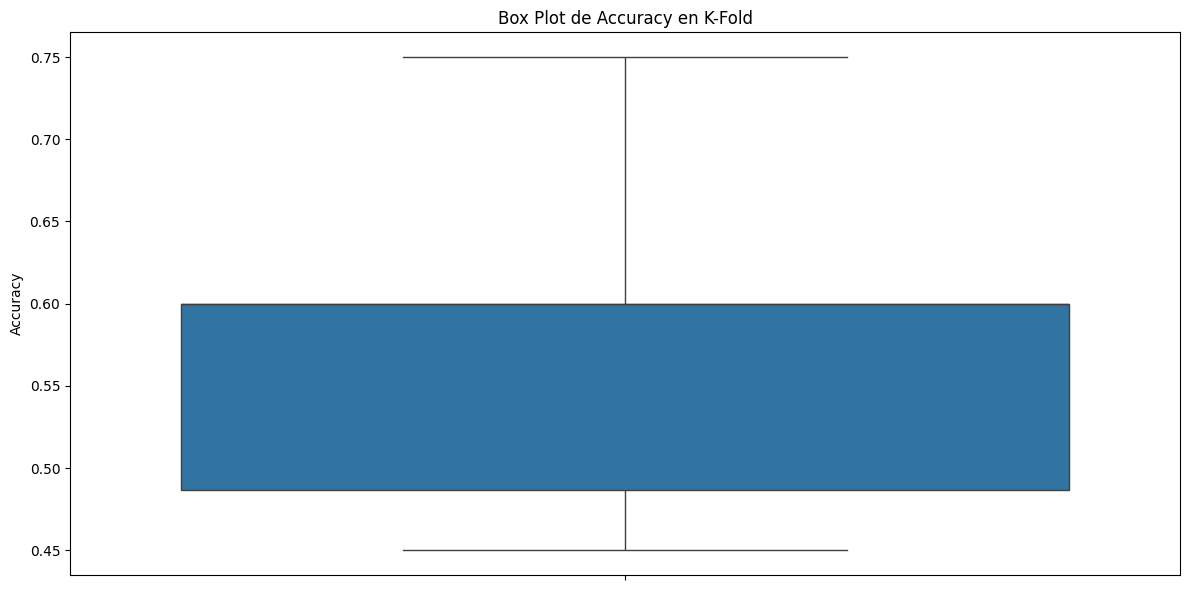

/n Testeo....
Accuracy en conjunto de prueba: 0.7166666666666667
Classification Report en conjunto de prueba:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       0.93      0.81      0.87        16
           2       0.90      0.69      0.78        13
           3       0.50      0.50      0.50         6
           4       0.75      0.60      0.67         5
           5       0.00      0.00      0.00         5

    accuracy                           0.72        60
   macro avg       0.62      0.60      0.60        60
weighted avg       0.71      0.72      0.70        60



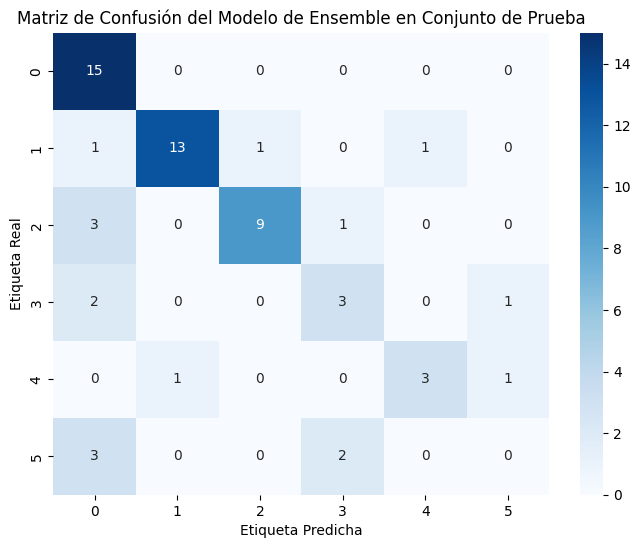

In [10]:
# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418

# Supongamos que 'text' son las frases y 'target' es la columna de clase
X = df['textos']  # Frases
y = df['administracion']  # Clases

# Dividir los datos en conjuntos de entrenamiento y prueba con un split del 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random, stratify=y)

# Vectorización de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Crear los clasificadores individuales
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random)
rf = RandomForestClassifier(n_estimators=100, random_state=random)
log_reg = LogisticRegression(max_iter=1000)
gb = GradientBoostingClassifier(random_state=random)
svm = SVC(probability=True, random_state=random)  # SVM con probabilidades para VotingClassifier

# Crear el modelo de ensemble usando VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
       # ('xgb', xgb),
        ('rf', rf),
        ('log_reg', log_reg),
        ('gb', gb),
       # ('svm', svm)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)

# K-Fold Cross Validation
kf = KFold(n_splits=7, shuffle=True, random_state=random)  # 5 n_splits
accuracy_scores = []

for train_index, test_index in kf.split(X_train_tfidf):
    X_train_fold, X_test_fold = X_train_tfidf[train_index], X_train_tfidf[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ajustar el modelo de ensemble
    ensemble_model.fit(X_train_fold, y_train_fold)
    
    # Realizar predicciones
    y_pred_fold = ensemble_model.predict(X_test_fold)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy)
    print("Classification Report en conjunto de entrenamiento:\n", classification_report(y_test_fold, y_pred_fold))

# Box Plot de las métricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=accuracy_scores)
plt.title('Box Plot de Accuracy en K-Fold')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de entrenamiento
ensemble_model.fit(X_train_tfidf, y_train)

print("/n Testeo....")

# Evaluar el modelo en el conjunto de prueba
y_pred_test = ensemble_model.predict(X_test_tfidf)

# Métricas finales en conjunto de prueba
print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_pred_test))
print("Classification Report en conjunto de prueba:\n", classification_report(y_test, y_pred_test))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

# Ensemble 2

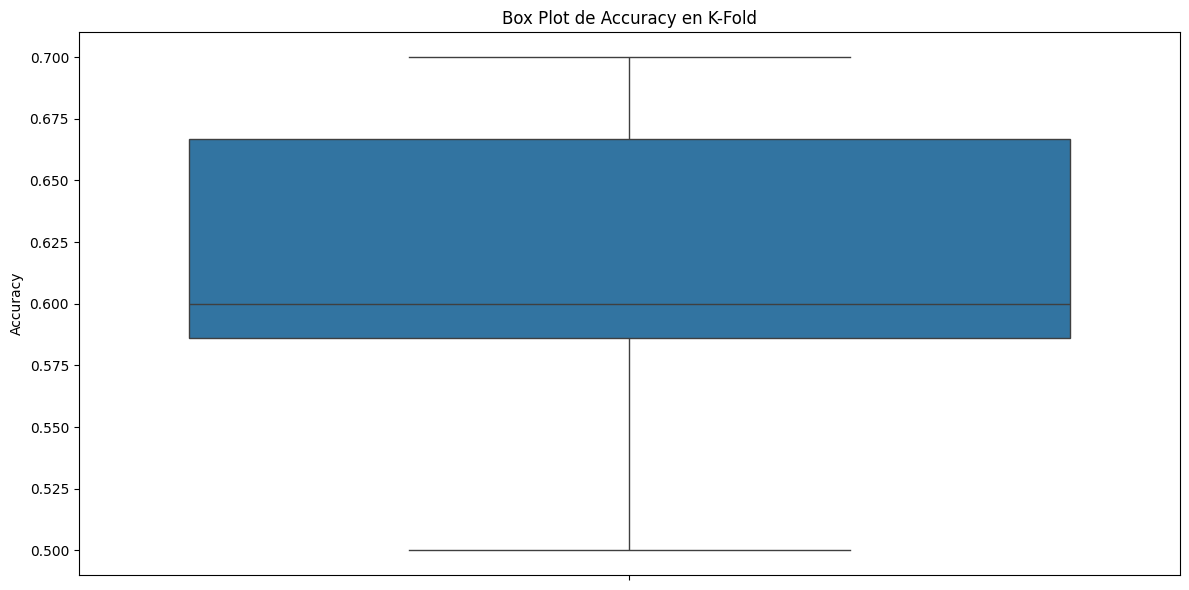

Resultados en conjunto de prueba:
Accuracy en conjunto de prueba: 0.66
Classification Report en conjunto de prueba:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        12
           1       0.77      0.77      0.77        13
           2       0.70      0.64      0.67        11
           3       0.67      0.40      0.50         5
           4       1.00      0.20      0.33         5
           5       1.00      0.25      0.40         4

    accuracy                           0.66        50
   macro avg       0.78      0.54      0.56        50
weighted avg       0.73      0.66      0.63        50



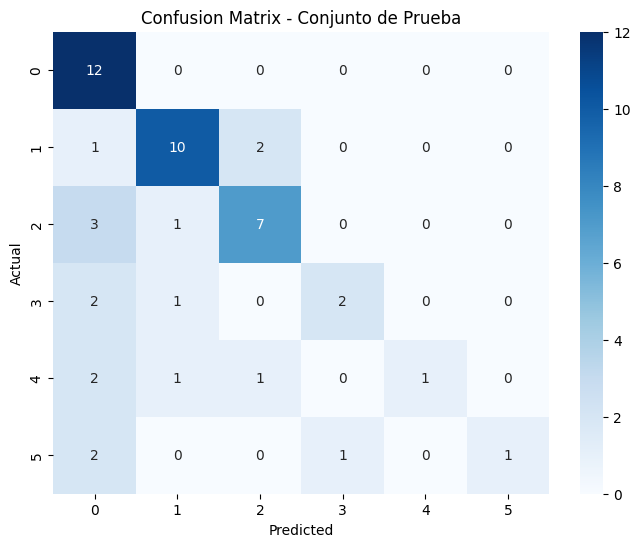

In [11]:
# Cargar y preparar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', encoding='utf-8-sig', delimiter=';')
X = df['textos']  # Frases
y = df['administracion']  # Clases

# División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Vectorización de textos con TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Modelos de clasificación
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Voting ensemble con soft voting
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('log_reg', log_reg), ('gb', gb), ('svm', svm)],
    voting='soft'
)

# Entrenamiento y predicción
ensemble_model.fit(X_train_tfidf, y_train)

# Validación cruzada con KFold en el conjunto de entrenamiento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, test_index in kf.split(X_train_tfidf):
    X_train_fold, X_test_fold = X_train_tfidf[train_index], X_train_tfidf[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ajuste y predicción
    ensemble_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = ensemble_model.predict(X_test_fold)

    # Cálculo de métricas
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy)

# Boxplot de resultados de K-Fold
plt.figure(figsize=(12, 6))
sns.boxplot(data=accuracy_scores)
plt.title('Box Plot de Accuracy en K-Fold')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


# Entrenamiento y predicción
ensemble_model.fit(X_train_tfidf, y_train)

# Evaluación en el conjunto de prueba
y_test_pred = ensemble_model.predict(X_test_tfidf)

# Resultados en el conjunto de prueba
print("Resultados en conjunto de prueba:")
print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_test_pred))
print("Classification Report en conjunto de prueba:\n", classification_report(y_test, y_test_pred))

# Matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d", xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Conjunto de Prueba")
plt.show()

# Ensemble 3 

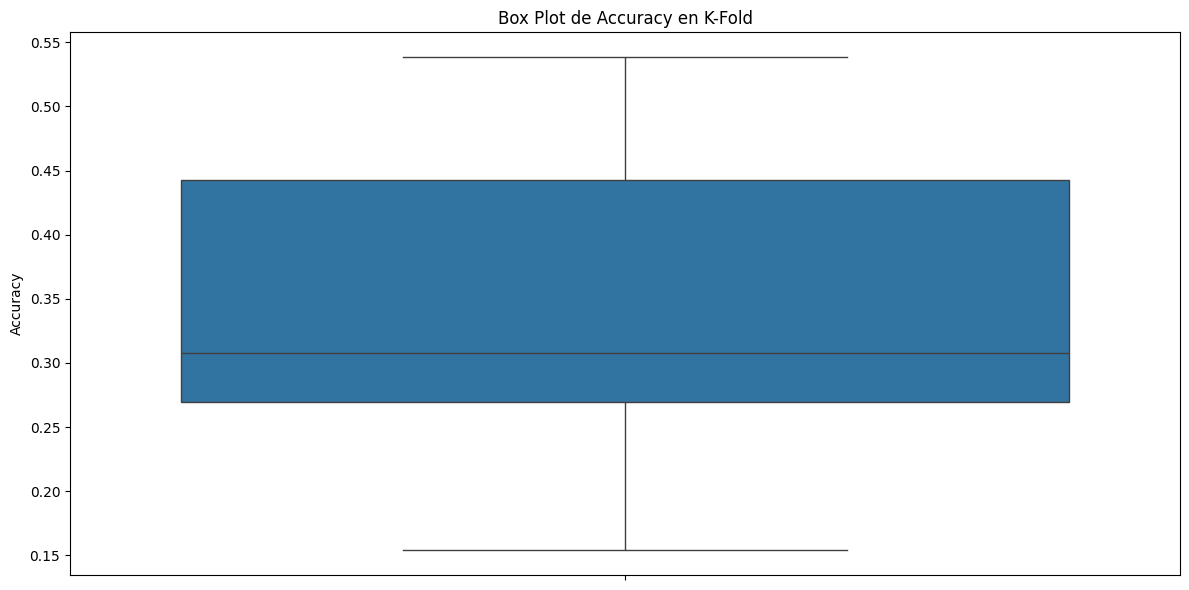

Accuracy en conjunto de prueba: 0.45
Classification Report en conjunto de prueba:
               precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       1.00      0.50      0.67        10
           2       0.43      0.33      0.38         9
           3       0.25      0.25      0.25         4
           4       0.67      0.67      0.67         3
           5       0.20      0.50      0.29         4

    accuracy                           0.45        40
   macro avg       0.50      0.46      0.45        40
weighted avg       0.56      0.45      0.47        40



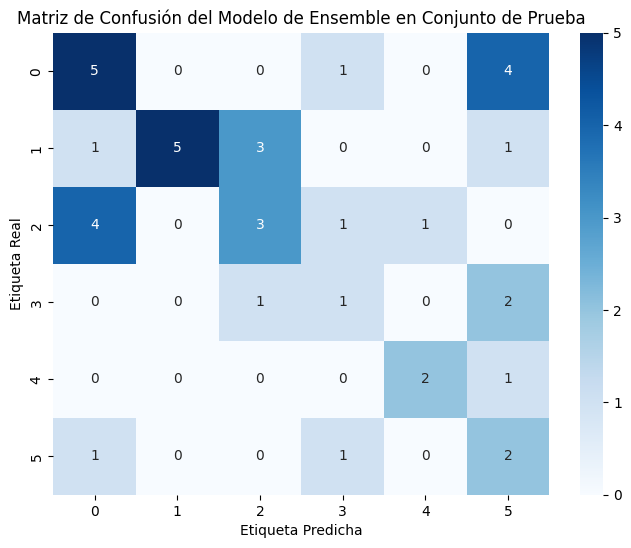

In [8]:
# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418

# Supongamos que 'text' son las frases y 'target' es la columna de clase
X = df['textos']  # Frases
y = df['administracion']  # Clases

# Dividir los datos en conjuntos de entrenamiento y prueba con un split del x%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random, stratify=y)

# Vectorización de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Aplicar undersampling para balancear las clases en el conjunto de entrenamiento
undersampler = RandomUnderSampler(random_state=random)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_tfidf, y_train)

# Crear los clasificadores individuales
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random)
rf = RandomForestClassifier(n_estimators=100, random_state=random)
log_reg = LogisticRegression(max_iter=1000)
gb = GradientBoostingClassifier(random_state=random)
svm = SVC(probability=True, random_state=random)  # SVM con probabilidades para VotingClassifier

# Crear el modelo de ensemble usando VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('log_reg', log_reg),
        ('gb', gb),
        ('svm', svm)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)

# K-Fold Cross Validation
kf = KFold(n_splits=7, shuffle=True, random_state=random)  # Especificar n_splits
accuracy_scores = []

for train_index, test_index in kf.split(X_train_balanced):
    X_train_fold, X_test_fold = X_train_balanced[train_index], X_train_balanced[test_index]
    y_train_fold, y_test_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[test_index]
    
    # Ajustar el modelo de ensemble
    ensemble_model.fit(X_train_fold, y_train_fold)
    
    # Realizar predicciones
    y_pred_fold = ensemble_model.predict(X_test_fold)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy)

# Box Plot de las métricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=accuracy_scores)
plt.title('Box Plot de Accuracy en K-Fold')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_pred_test = gb.predict(X_test_tfidf)

# Métricas finales en conjunto de prueba
print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_pred_test))
print("Classification Report en conjunto de prueba:\n", classification_report(y_test, y_pred_test))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

## Undersampler con xgb

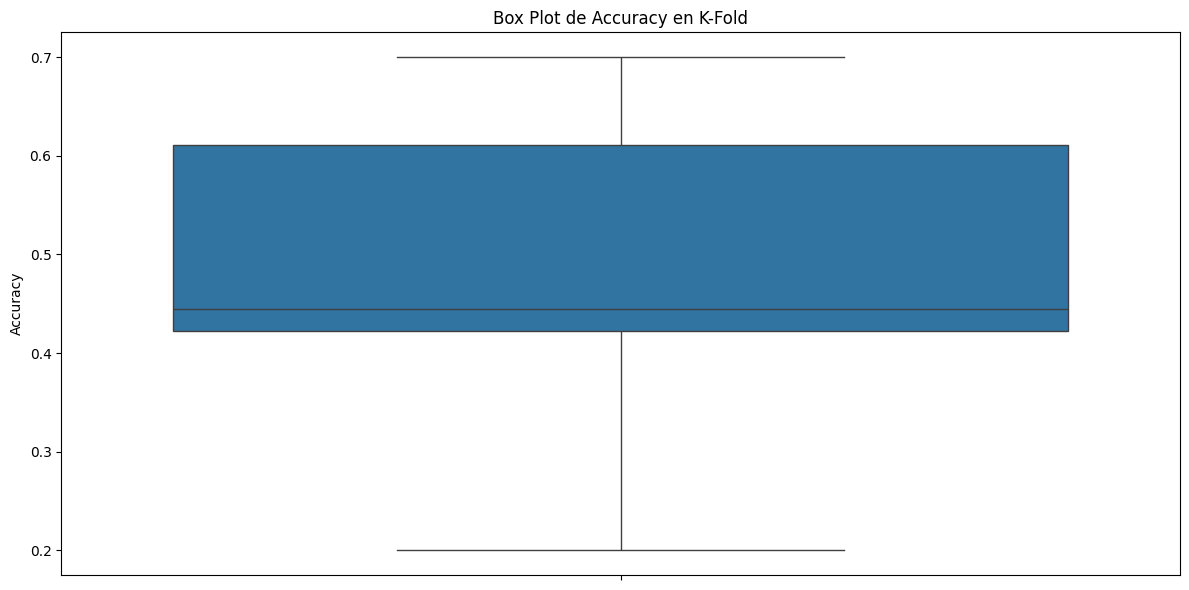

Accuracy en conjunto de prueba: 0.5135135135135135
Classification Report en conjunto de prueba:
               precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.62      0.50      0.56        10
           2       0.29      0.25      0.27         8
           3       1.00      0.67      0.80         3
           4       0.29      0.67      0.40         3
           5       1.00      0.33      0.50         3

    accuracy                           0.51        37
   macro avg       0.63      0.52      0.53        37
weighted avg       0.57      0.51      0.52        37



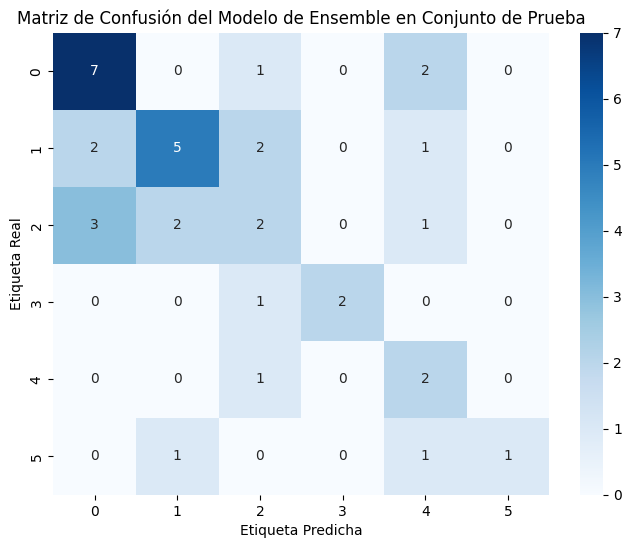

In [7]:
# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418

# Supongamos que 'text' son las frases y 'target' es la columna de clase
X = df['textos']  # Frases
y = df['administracion']  # Clases

# Dividir los datos en conjuntos de entrenamiento y prueba con un split del x%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random, stratify=y)

# Vectorización de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Aplicar undersampling para balancear las clases en el conjunto de entrenamiento
undersampler = RandomUnderSampler(random_state=random)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_tfidf, y_train)

# Crear los clasificadores individuales
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random)
gb = GradientBoostingClassifier(random_state=random)
svm = SVC(probability=True, random_state=random)  # SVM con probabilidades para VotingClassifier



# K-Fold Cross Validation
kf = KFold(n_splits=7, shuffle=True, random_state=random)  # Especificar n_splits
accuracy_scores = []

for train_index, test_index in kf.split(X_train_balanced):
    X_train_fold, X_test_fold = X_train_balanced[train_index], X_train_balanced[test_index]
    y_train_fold, y_test_fold = y_train_balanced.iloc[train_index], y_train_balanced.iloc[test_index]
    
    # Ajustar el modelo de ensemble
    xgb.fit(X_train_fold, y_train_fold)
    
    # Realizar predicciones
    y_pred_fold = xgb.predict(X_test_fold)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_scores.append(accuracy)

# Box Plot de las métricas
plt.figure(figsize=(12, 6))
sns.boxplot(data=accuracy_scores)
plt.title('Box Plot de Accuracy en K-Fold')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_pred_test = xgb.predict(X_test_tfidf)

# Métricas finales en conjunto de prueba
print("Accuracy en conjunto de prueba:", accuracy_score(y_test, y_pred_test))
print("Classification Report en conjunto de prueba:\n", classification_report(y_test, y_pred_test))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

# embeddings BERT (transformer)

In [6]:
# 1. Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# 2. Procesamiento de etiquetas (conviértelo a listas si no lo están)
df['administracion'] = df['administracion'].apply(lambda x: eval(x) if isinstance(x, str) else x)
X_text = df['textos']
# Asegurarnos de que las etiquetas están en formato de lista
y_labels = df['administracion'].apply(lambda x: [x] if isinstance(x, int) else x)

# Codificar etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_labels)


# 3. Tokenización y Embeddings usando BERT
bert_model_name = "bert-base-uncased"  # Puedes cambiarlo a otro modelo BERT si deseas
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Tokenizar textos y convertir a embeddings BERT
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(), max_length=100, padding='max_length', truncation=True, return_tensors="tf"
    )

X_tokenized = tokenize_texts(X_text)
X_embeddings = bert_model(X_tokenized['input_ids']).last_hidden_state
X_pooled = tf.reduce_mean(X_embeddings, axis=1)  # Reducimos a un solo vector por texto
X_pooled = X_pooled.numpy()
    

# 4. Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_pooled, y, test_size=0.3, random_state=42)

# 5. Modelo de Red Neuronal
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_pooled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='sigmoid')  # Salida multietiqueta
])

# Compilar el modelo
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['recall'])

# Entrenar el modelo de Red Neuronal
history_nn = model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo de Red Neuronal
y_pred_nn = (model_nn.predict(X_test) > 0.5).astype(int)
target_names = [str(c) for c in mlb.classes_]
print("Red Neuronal - Evaluación")
print(classification_report(y_test, y_pred_nn, target_names=target_names))
print("Accuracy:", accuracy_score(y_test, y_pred_nn))

# 6. Modelo de Ensemble - Random Forest
# Convertir los embeddings a matrices planas para el modelo Random Forest
X_train_flat = np.array(X_train)
X_test_flat = np.array(X_test)

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
rf_model.fit(X_train_flat, y_train)

# Evaluar el modelo de Random Forest
y_pred_rf = rf_model.predict(X_test_flat)
print("Random Forest - Evaluación")
print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.6663 - recall: 0.4076 - val_loss: 0.5893 - val_recall: 0.2857
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6295 - recall: 0.3531 - val_loss: 0.5568 - val_recall: 0.1786
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6149 - recall: 0.3218 - val_loss: 0.5267 - val_recall: 0.1786
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5519 - recall: 0.3185 - val_loss: 0.4912 - val_recall: 0.0714
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5328 - recall: 0.3665 - val_loss: 0.4636 - val_recall: 0.1429
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5718 - recall: 0.2874 - val_loss: 0.4514 - val_recall: 0.0714
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5529 - recall: 0.2676 - val_loss: 0.4528 - val_recall: 0.0357
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5036 - recall: 0.3729 - val_loss: 0.4553 - val_recall: 0.0357
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━

# Multilabel

In [13]:
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear una nueva columna transformando la columna 'administracion'
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

# Características y etiquetas
X = df['textos']  # Características
y = df['administracion_multi']  # Usar la nueva columna multiclase

# Convertir texto a características usando TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convertir a matriz 2D

# Codificación de las etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)  # Conversión a formato binario

# Calcular pesos de clase
unique_classes = np.unique(y_encoded.flatten())
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=unique_classes, 
    y=y_encoded.flatten()
)
class_weights_dict = {i: class_weights[i] for i in unique_classes}

# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)

# Definir el modelo
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))  # Primera capa oculta
model.add(Dropout(0.3))  # Capa de Dropout para prevenir el sobreajuste
model.add(Dense(64, activation='sigmoid'))  # Segunda capa oculta
model.add(Dropout(0.3))  # Otra capa de Dropout
model.add(Dense(16, activation='relu'))  # Tercera capa oculta
model.add(Dropout(0.3))  # Capa de Dropout
model.add(Dense(y_encoded.shape[1], activation='sigmoid'))  # Capa de salida con Sigmoid

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.2, class_weight=class_weights_dict)

# Evaluación en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Umbral para convertir las probabilidades en clases

# Imprimir las clases para verificar su contenido
print("Clases codificadas:", mlb.classes_)
print("Predicciones:", y_pred_classes)
print("Clases reales:", y_test)

# Reporte de clasificación
# Convertir las clases codificadas a un formato adecuado
print(classification_report(y_test, y_pred_classes, target_names=[str(c) for c in mlb.classes_]))

# Matriz de confusión para visualización
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))
print("Matriz de confusión:\n", conf_matrix)


Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1818 - loss: 1.0351 - val_accuracy: 0.3571 - val_loss: 0.7334
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2869 - loss: 0.8382 - val_accuracy: 0.3571 - val_loss: 0.6753
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3133 - loss: 0.7855 - val_accuracy: 0.3571 - val_loss: 0.6473
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3464 - loss: 0.7278 - val_accuracy: 0.3571 - val_loss: 0.6297
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3133 - loss: 0.6858 - val_accuracy: 0.3571 - val_loss: 0.6174
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3761 - loss: 0.7027 - val_accuracy: 0.3571 - val_loss: 0.6038
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3291 - loss: 0.6735 - val_accuracy: 0.3571 - val_loss: 0.5952
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3098 - loss: 0.6593 - val_accuracy: 0.3571 - val_loss: 0.5884

# Sentence Transformers

In [79]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Inicializar el modelo de embeddings
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

segunda_linea = [
    "han recibido tratamiento previo",
    "han tenido terapia antes",
    "han sido tratados previamente",
    "han recibido medicación antes",
    "han tenido tratamiento médico previo",
    'Con tratamiento previo'
    'un tratamiento sistémico previo',
    'han sido previamente tratados',
    'al menos, un tratamiento sistémico',
    'al menos, un tratamiento',
    'han recibido terapia sistémica previa',
    'al menos una terapia previa',
    'han recibido quimioterapia previa',
    'al menos, un régimen de quimioterapia',
    'han recibido al menos un tratamiento previo',
    'al menos un tratamiento previo',
    'segunda línea',
    'cuya enfermedad no haya presentado progresión después de quimiorradioterapia basada en platino',
    'hayan sido tratados previamente',
    
]

primera_linea = [
    "no han recibido tratamiento previo",
    "no han tenido terapia antes",
    "no han sido tratados previamente",
    "no han recibido medicación antes",
    "no han tenido tratamiento médico previo",
    'sin tratamiento previo',
    'no han recibido quimioterapia previamente',
    'no tratados previamente',
    'en primera remisión tratados',
    'no han sido previamente tratados',
    'primera línea',

]


tercena_linea = [
    'han recibido al menos tres tratamientos previos',
    'después de al menos dos tratamientos previos',
    'al menos tres tratamientos previos',
    'tercera línea',
    
]


csv_path = r"C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\data\Excel\datos_de_los_medicamentos.csv"
df = pd.read_csv(csv_path , encoding='utf-8-sig')
textos = df['Descripcion_patologia']


# Función para dividir el texto con una ventana deslizante
def dividir_texto(texto, tamaño_ventana):
    palabras = texto.split()
    fragmentos = [' '.join(palabras[i:i+tamaño_ventana]) for i in range(len(palabras) - tamaño_ventana + 1)]
    return fragmentos

# Listas para almacenar los resultados finales
resultados_similitud = []
resultados_linea = []
resultados_frag = []
porcentaje = 0.8

for texto_largo in textos:
    fragmentos = dividir_texto(texto_largo, 5)

    # Calcular representaciones numéricas de las líneas de referencia
    embeddings1 = model.encode(primera_linea)
    embeddings2 = model.encode(segunda_linea)
    embeddings3 = model.encode(tercena_linea)

    similitud = []
    linea = []
    frag = []

    for fragmento in fragmentos:
        embedding_fragmento = model.encode([fragmento])

        # Calcular similitudes con primera_linea
        similarities1 = util.pytorch_cos_sim(embedding_fragmento, embeddings1)
        for idx_i, sentence1 in enumerate(primera_linea):
            similarity_score = similarities1[0][idx_i].item()
            if similarity_score > porcentaje:
                similitud.append(similarity_score)
                linea.append("primera_linea")
                frag.append(fragmento)

        # Calcular similitudes con segunda_linea
        similarities2 = util.pytorch_cos_sim(embedding_fragmento, embeddings2)
        for idx_i, sentence2 in enumerate(segunda_linea):
            similarity_score = similarities2[0][idx_i].item()
            if similarity_score > porcentaje:
                similitud.append(similarity_score)
                linea.append("segunda_linea")
                frag.append(fragmento)

        # Calcular similitudes con tercera_linea
        similarities3 = util.pytorch_cos_sim(embedding_fragmento, embeddings3)
        for idx_i, sentence3 in enumerate(tercena_linea):
            similarity_score = similarities3[0][idx_i].item()
            if similarity_score > porcentaje:
                similitud.append(similarity_score)
                linea.append("tercena_linea")
                frag.append(fragmento)

    # Crear un DataFrame temporal con los resultados del texto actual
    df_temp = pd.DataFrame({
        'similitud': similitud,
        'linea': linea,
        'frag': frag
    })

    # Seleccionar la fila con la similitud más alta para cada tipo de línea
    df_max_similitud_por_linea = df_temp.loc[df_temp.groupby('linea')['similitud'].idxmax()]

    # Guardar los resultados en las listas finales
    resultados_similitud.append(df_max_similitud_por_linea['similitud'].tolist())
    resultados_linea.append(df_max_similitud_por_linea['linea'].tolist())
    resultados_frag.append(df_max_similitud_por_linea['frag'].tolist())

# Crear un DataFrame final con los resultados
df_final = pd.DataFrame({
    'textos': textos,
    'similitud': resultados_similitud,
    'linea': resultados_linea,
    'frag': resultados_frag
})


df_final

,textos,similitud,linea,frag
0,abecma está indicado para el tratamiento de p...,"[0.8109230995178223, 0.9957789182662964]","[segunda_linea, tercena_linea]","[que han recibido al menos, al menos tres trat..."
1,linfoma anaplásico de células grandes sistémi...,"[0.8069086670875549, 1.0]","[primera_linea, segunda_linea]","[sin tratamiento previo. adcetris está, al men..."
2,linfoma de hodgkin adcetris está indicado par...,"[0.9171532988548279, 0.9097827076911926]","[primera_linea, tercena_linea]","[o iv sin tratamiento previo, de al menos dos ..."
3,akeega está indicado con prednisona o prednis...,[],[],[]
4,alecensa en monoterapia está indicado para el...,"[0.9386892318725586, 0.9542174935340881]","[primera_linea, segunda_linea]","[primera línea o - que, han sido previamente t..."
...,...,...,...,...
179,cáncer de pulmón no microcítico (cpn yervoy e...,[0.8324669003486633],[primera_linea],[para el tratamiento de primera]
180,melanoma yervoy en monoterapia está indicado...,[],[],[]
181,mesotelioma pleural maligno (mp yervoy en com...,[0.8324669003486633],[primera_linea],[para el tratamiento de primera]
182,en relación con nivolumab en monoterapia se h...,[0.8324669003486633],[primera_linea],[para el tratamiento de primera]


 probar con lista creada (no hay buenos resultados)

In [112]:
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')
 
segunda_linea = []
primera_linea = []
tercera_linea = []
no_hay_linea = []

# Segunda línea: primeros 5 de administracion == 2, primeros 4 de administracion == 4, primeros 4 de administracion == 4
segunda_linea += df[df['administracion'] == 2].head(5)['textos'].tolist()
segunda_linea += df[df['administracion'] == 4].head(4)['textos'].tolist()
segunda_linea += df[df['administracion'] == 4].head(4)['textos'].tolist()

# Primera línea: primeros 7 de administracion == 1, primeros 7 de administracion == 4
primera_linea += df[df['administracion'] == 1].head(7)['textos'].tolist()
primera_linea += df[df['administracion'] == 4].head(7)['textos'].tolist()

# Tercera línea: primeros 7 de administracion == 3, primeros 7 de administracion == 5
tercera_linea += df[df['administracion'] == 3].head(7)['textos'].tolist()
tercera_linea += df[df['administracion'] == 5].head(7)['textos'].tolist()

# No hay línea: primeros 14 de administracion == 0
no_hay_linea += df[df['administracion'] == 0].head(14)['textos'].tolist()

Segunda Línea:
[' alimta en monoterapia está indicado como tratamiento de mantenimiento de pacientes con cáncer de pulmón no micro cítico localmente avanzado o metastásico, salvo aquéllos que tengan histología predominantemente de célula escamosa, cuya enfermedad no ha progresado inmediatamente después de un régimen quimioterápico basado en un platino', ' mastocitosis sistémica avanzada (msa ayvakyt está indicado como monoterapia para el tratamiento de pacientes adultos con mastocitosis sistémica agresiva (ms , mastocitosis sistémica con neoplasia hematológica asociada (ms -nh o leucemia mastocítica (l después de, al menos, un tratamiento sistémico', ' encorafenib está indicado: en combinación con binimetinib en adultos para el tratamiento del melanoma no resecable o metastásico con mutación braf v600 (ver las secciones 4. 4 y 5.  en combinación con cetuximab, par a el tratamiento de pacientes adultos con cáncer colorrectal metastásico (ccr con mutación braf v600e, que han recibido ter

In [117]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Inicializar el modelo de embeddings
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Cargar el DataFrame de las patologías
csv_path = r"C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\data\Excel\datos_de_los_medicamentos.csv"
df = pd.read_csv(csv_path , encoding='utf-8-sig')
textos = df['Descripcion_patologia']

# Función para dividir el texto con una ventana deslizante
def dividir_texto(texto, tamaño_ventana):
    palabras = texto.split()
    fragmentos = [' '.join(palabras[i:i+tamaño_ventana]) for i in range(len(palabras) - tamaño_ventana + 1)]
    return fragmentos

# Listas para almacenar los resultados finales
resultados_similitud = []
resultados_linea = []
resultados_frag = []
porcentaje = 0.5

for texto_largo in textos:
    fragmentos = dividir_texto(texto_largo, 16)

    # Calcular representaciones numéricas de las líneas de referencia
    embeddings1 = model.encode(primera_linea)
    embeddings2 = model.encode(segunda_linea)
    embeddings3 = model.encode(tercena_linea) if len(tercena_linea) > 0 else []  # Verificar si no está vacío
    embeddings0 = model.encode(no_hay_linea) if len(no_hay_linea) > 0 else []  # Verificar si no está vacío

    similitud = []
    linea = []
    frag = []

    for fragmento in fragmentos:
        embedding_fragmento = model.encode([fragmento])

        # Calcular similitudes con primera_linea
        similarities1 = util.pytorch_cos_sim(embedding_fragmento, embeddings1)
        for idx_i, sentence1 in enumerate(primera_linea):
            similarity_score = similarities1[0][idx_i].item()
            if similarity_score > porcentaje:
                similitud.append(similarity_score)
                linea.append("primera_linea")
                frag.append(fragmento)

        # Calcular similitudes con segunda_linea
        similarities2 = util.pytorch_cos_sim(embedding_fragmento, embeddings2)
        for idx_i, sentence2 in enumerate(segunda_linea):
            similarity_score = similarities2[0][idx_i].item()
            if similarity_score > porcentaje:
                similitud.append(similarity_score)
                linea.append("segunda_linea")
                frag.append(fragmento)

        # Calcular similitudes con tercera_linea si no está vacía
        if len(embeddings3) > 0:  # Usamos len(embeddings3) para evitar el error
            similarities3 = util.pytorch_cos_sim(embedding_fragmento, embeddings3)
            for idx_i, sentence3 in enumerate(tercena_linea):
                similarity_score = similarities3[0][idx_i].item()
                if similarity_score > porcentaje:
                    similitud.append(similarity_score)
                    linea.append("tercena_linea")
                    frag.append(fragmento)

        # Calcular similitudes con no_hay_linea si no está vacía
        if len(embeddings0) > 0:  # Usamos len(embeddings0) para evitar el error
            similarities0 = util.pytorch_cos_sim(embedding_fragmento, embeddings0)
            for idx_i, sentence0 in enumerate(no_hay_linea):
                similarity_score = similarities0[0][idx_i].item()
                if similarity_score > porcentaje:
                    similitud.append(similarity_score)
                    linea.append("no_hay_linea")
                    frag.append(fragmento)

    # Crear un DataFrame temporal con los resultados del texto actual
    df_temp = pd.DataFrame({
        'similitud': similitud,
        'linea': linea,
        'frag': frag
    })

    # Seleccionar la fila con la similitud más alta para cada tipo de línea
    df_max_similitud_por_linea = df_temp.loc[df_temp.groupby('linea')['similitud'].idxmax()]

    # Guardar los resultados en las listas finales
    resultados_similitud.append(df_max_similitud_por_linea['similitud'].tolist())
    resultados_linea.append(df_max_similitud_por_linea['linea'].tolist())
    resultados_frag.append(df_max_similitud_por_linea['frag'].tolist())

# Crear un DataFrame final con los resultados
df_final = pd.DataFrame({
    'textos': textos,
    'similitud': resultados_similitud,
    'linea': resultados_linea,
    'frag': resultados_frag
})

df_final

,textos,similitud,linea,frag
0,abecma está indicado para el tratamiento de p...,"[0.6472950577735901, 0.7451687455177307, 0.614...","[no_hay_linea, primera_linea, segunda_linea]",[abecma está indicado para el tratamiento de p...
1,linfoma anaplásico de células grandes sistémi...,"[0.7065733075141907, 0.8769728541374207, 0.876...","[no_hay_linea, primera_linea, segunda_linea]",[para el tratamiento de pacientes adultos con ...
2,linfoma de hodgkin adcetris está indicado par...,"[0.666944146156311, 0.9049738049507141, 0.9049...","[no_hay_linea, primera_linea, segunda_linea]",[tólogo de células madre (tac . adcetris está ...
3,akeega está indicado con prednisona o prednis...,"[0.9048807621002197, 0.7526003122329712, 0.752...","[no_hay_linea, primera_linea, segunda_linea]",[akeega está indicado con prednisona o prednis...
4,alecensa en monoterapia está indicado para el...,"[0.7998911142349243, 0.9291443824768066, 0.929...","[no_hay_linea, primera_linea, segunda_linea]",[en monoterapia está indicado para el tratamie...
...,...,...,...,...
179,cáncer de pulmón no microcítico (cpn yervoy e...,"[0.797457754611969, 0.8490316271781921, 0.7160...","[no_hay_linea, primera_linea, segunda_linea]",[está indicad o para el tratamiento de primera...
180,melanoma yervoy en monoterapia está indicado...,"[0.8767178654670715, 0.7051417827606201, 0.761...","[no_hay_linea, primera_linea, segunda_linea]",[en monoterapia está indicado para el tratamie...
181,mesotelioma pleural maligno (mp yervoy en com...,"[0.66092848777771, 0.7860955595970154, 0.71578...","[no_hay_linea, primera_linea, segunda_linea]",[combinación con nivolumab está ind icado para...
182,en relación con nivolumab en monoterapia se h...,"[0.7297036647796631, 0.8778501749038696, 0.775...","[no_hay_linea, primera_linea, segunda_linea]",[nivolumab está indicado para el tratamiento d...


In [119]:
df_final['frag'][0]

['abecma está indicado para el tratamiento de pacientes adultos con mieloma múltiple en recaída y refractario',
 'indicado para el tratamiento de pacientes adultos con mieloma múltiple en recaída y refractario que han',
 'está indicado para el tratamiento de pacientes adultos con mieloma múltiple en recaída y refractario que']

# Opciones multiclase

El mejor modelo ha sido el modelo de gracient boosting

In [73]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear etiquetas multiclase
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

X = df['textos']
y = df['administracion_multi']

# Convertir etiquetas multiclase en formato binario
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

# Dividir los datos en entrenamiento y prueba
random = 81418
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.20, random_state=random, stratify=y_bin)

# Vectorización con TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Función para mostrar métricas
def mostrar_métricas(y_test, y_pred, modelo):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=mlb.classes_.astype(str))
    print(f"\nResultados del modelo {modelo}:")
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Classification Report:\n", report)

# Red Neuronal Multietiqueta con Sigmoides
def modelo_red_neuronal(X_train, X_test, y_train, y_test):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(mlb.classes_), activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    mostrar_métricas(y_test, y_pred, "Red Neuronal")

# Random Forest en Configuración Multietiqueta
def modelo_random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=random, n_jobs=-1)
    clf = MultiOutputClassifier(rf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mostrar_métricas(y_test, y_pred, "Random Forest")

# Gradient Boosting en Configuración Multietiqueta
def modelo_gradient_boosting(X_train, X_test, y_train, y_test):
    gb = GradientBoostingClassifier(random_state=random)
    clf = MultiOutputClassifier(gb)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mostrar_métricas(y_test, y_pred, "Gradient Boosting")

# Ejecutar los modelos
print("Entrenando Red Neuronal...")
modelo_red_neuronal(X_train_tfidf, X_test_tfidf, y_train, y_test)

print("\nEntrenando Random Forest...")
modelo_random_forest(X_train_tfidf, X_test_tfidf, y_train, y_test)

print("\nEntrenando Gradient Boosting...")
modelo_gradient_boosting(X_train_tfidf, X_test_tfidf, y_train, y_test)


Entrenando Red Neuronal...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2874 - loss: 0.6909 - val_accuracy: 0.4062 - val_loss: 0.6855
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3878 - loss: 0.6789 - val_accuracy: 0.4062 - val_loss: 0.6769
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4806 - loss: 0.6643 - val_accuracy: 0.4062 - val_loss: 0.6675
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4327 - loss: 0.6492 - val_accuracy: 0.4375 - val_loss: 0.6561
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4818 - loss: 0.6303 - val_accuracy: 0.4375 - val_loss: 0.6431
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6102 - loss: 0.6048 - val_accuracy: 0.4375 - val_loss: 0.6290
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5099 - loss: 0.5840 - val_accuracy: 0.4375 - val_loss: 0.6146
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5330 - loss: 0.5570 - val_accuracy:

# Gradient Boosting mejorado multiclase

normal

F1-Score (Macro): 0.41
Accuracy: 0.22
Recall por clase: [0.05882353 0.7        0.26923077 0.33333333]


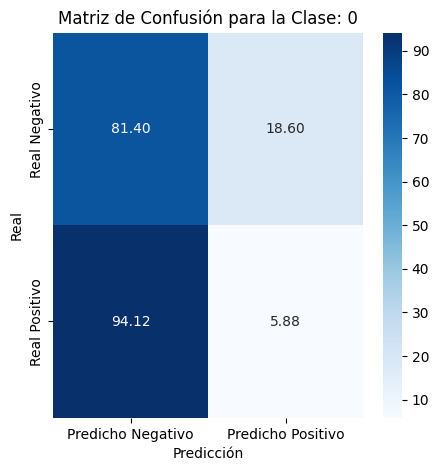

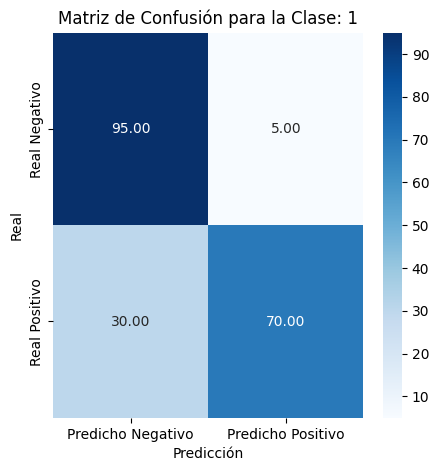

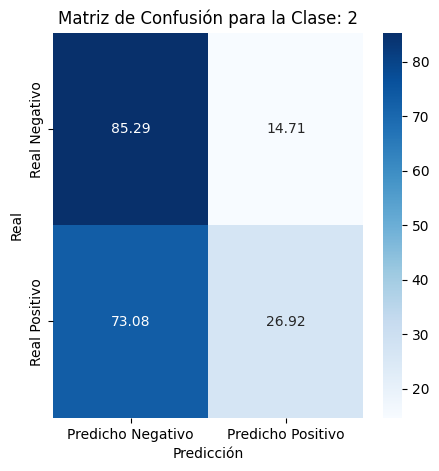

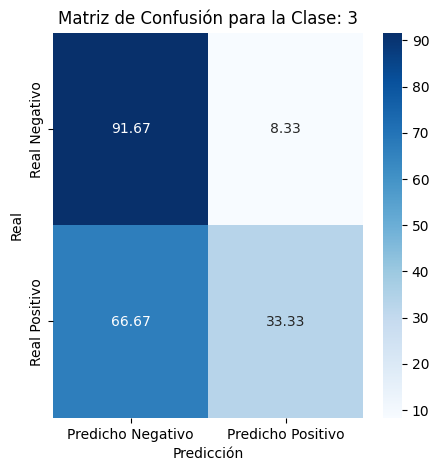

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear una nueva columna transformando la columna 'administracion'
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

# Características y etiquetas
X = df['textos']  # Características
y = df['administracion_multi']  # Usar la nueva columna multiclase

# Convertir texto a características usando TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convertir a matriz 2D

# Codificación de las etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)  # Conversión a formato binario

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)

# Crear el clasificador OneVsRest con GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)  # Solo random_state sin otros hiperparámetros
ovr = OneVsRestClassifier(gb)

# Entrenar el modelo sin GridSearchCV
ovr.fit(X_train, y_train)

# Predicciones
y_pred = ovr.predict(X_test)

# Evaluación con F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (Macro): {f1:.2f}")

# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calcular Recall para cada clase
recall = recall_score(y_test, y_pred, average=None)  # `average=None` para obtener recall por clase
print(f"Recall por clase: {recall}")

# Obtener la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Normalizar la matriz de confusión para que los valores estén en porcentaje
mcm_percentage = mcm.astype('float') / mcm.sum(axis=2)[:, :, np.newaxis] * 100

# Graficar cada matriz de confusión para cada clase con porcentajes
for i in range(len(mlb.classes_)):
    plt.figure(figsize=(5, 5))
    sns.heatmap(mcm_percentage[i], annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=["Predicho Negativo", "Predicho Positivo"], 
                yticklabels=["Real Negativo", "Real Positivo"])
    plt.title(f"Matriz de Confusión para la Clase: {mlb.classes_[i]}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


gridsearchcv

Fitting 3 folds for each of 12 candidates, totalling 36 fits
OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=10,
                                                         random_state=81418))
F1-Score (Macro): 0.54


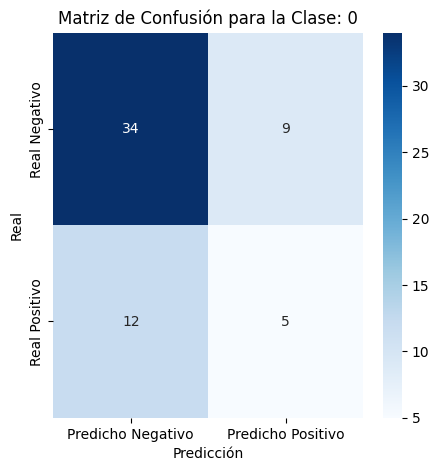

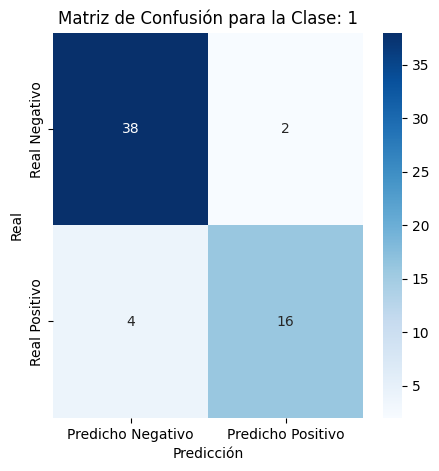

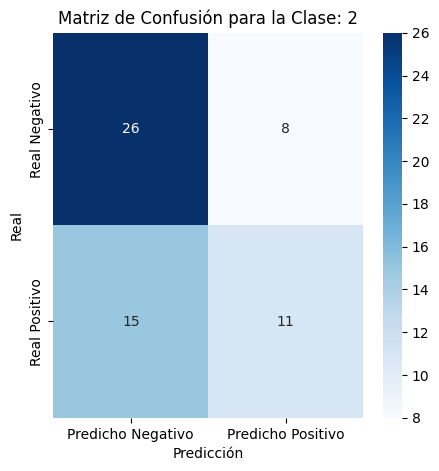

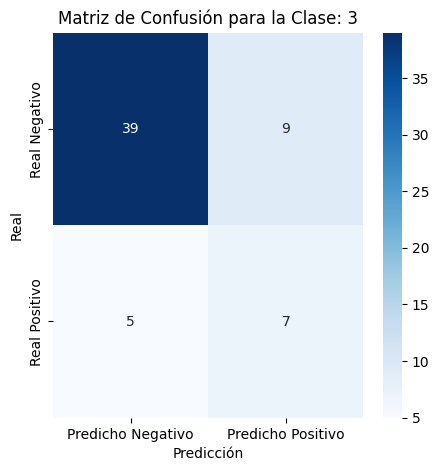

F1-Score (Macro): 0.54
Accuracy (Multilabel): 0.28


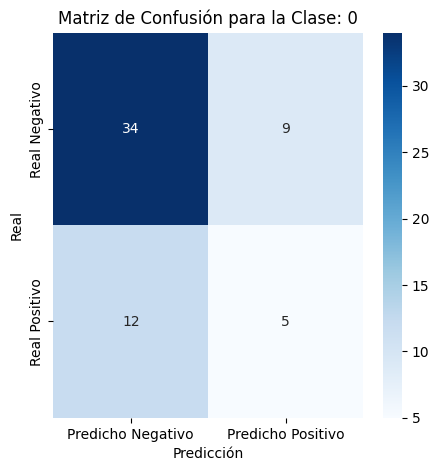

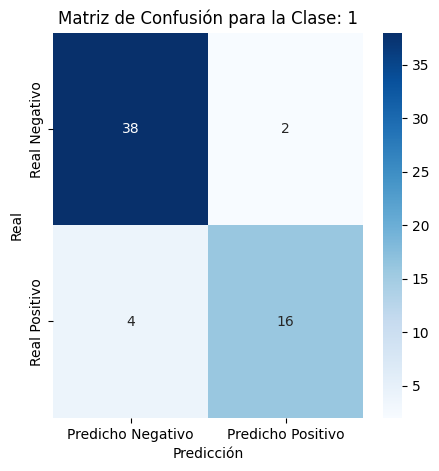

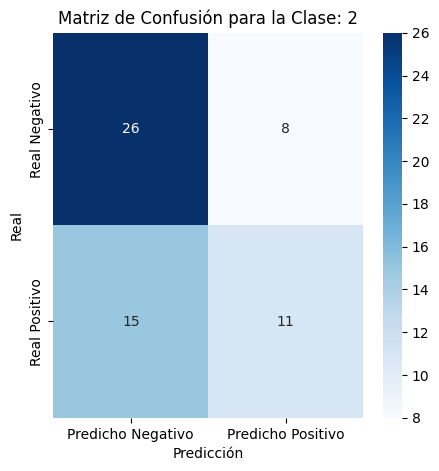

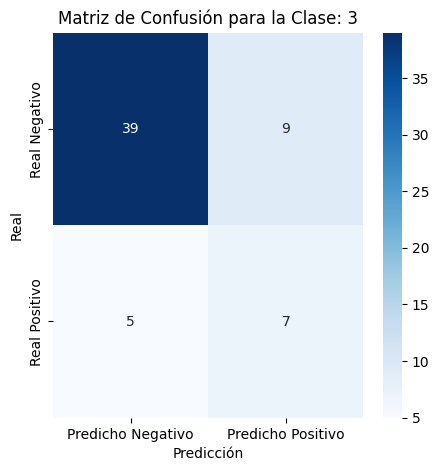

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear una nueva columna transformando la columna 'administracion'
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

# Características y etiquetas
X = df['textos']  # Características
y = df['administracion_multi']  # Usar la nueva columna multiclase

# Convertir texto a características usando TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convertir a matriz 2D

# Codificación de las etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)  # Conversión a formato binario

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)

# Crear el clasificador OneVsRest con GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random)
ovr = OneVsRestClassifier(gb)

# Configurar el GridSearchCV con el clasificador OneVsRest
param_grid = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [5, 10],
    'estimator__learning_rate': [0.05, 0.10]
}

grid_search = GridSearchCV(estimator=ovr, param_grid=param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_gb = grid_search.best_estimator_
print(best_gb)

# Predicciones
y_pred = best_gb.predict(X_test)

# Evaluación con F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (Macro): {f1:.2f}")

# Obtener la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Graficar cada matriz de confusión para cada clase con valores enteros
for i in range(len(mlb.classes_)):
    plt.figure(figsize=(5, 5))
    # Obtener la matriz de confusión para la clase i
    mcm_class = mcm[i]
    # Graficar la matriz de confusión con valores enteros
    sns.heatmap(mcm_class, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicho Negativo", "Predicho Positivo"], 
                yticklabels=["Real Negativo", "Real Positivo"])
    plt.title(f"Matriz de Confusión para la Clase: {mlb.classes_[i]}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()




from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score

# Predicciones
y_pred = best_gb.predict(X_test)

# Evaluación con F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (Macro): {f1:.2f}")

# Evaluación con Accuracy en contexto multilabel
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Multilabel): {accuracy:.2f}")

# Obtener la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Graficar cada matriz de confusión para cada clase con valores enteros
for i in range(len(mlb.classes_)):
    plt.figure(figsize=(5, 5))
    # Obtener la matriz de confusión para la clase i
    mcm_class = mcm[i]
    # Graficar la matriz de confusión con valores enteros
    sns.heatmap(mcm_class, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicho Negativo", "Predicho Positivo"], 
                yticklabels=["Real Negativo", "Real Positivo"])
    plt.title(f"Matriz de Confusión para la Clase: {mlb.classes_[i]}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


F1-Score (Macro): 0.53
Accuracy: 0.30
Recall por clase: [0.23529412 0.7        0.42307692 0.5       ]


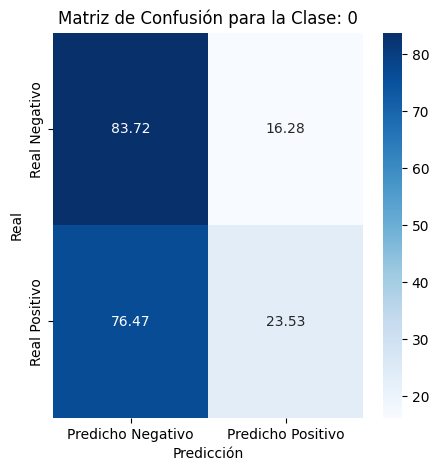

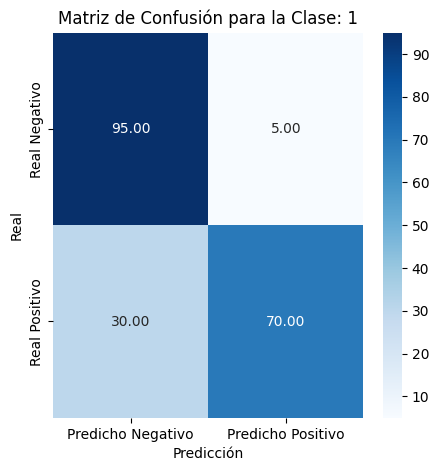

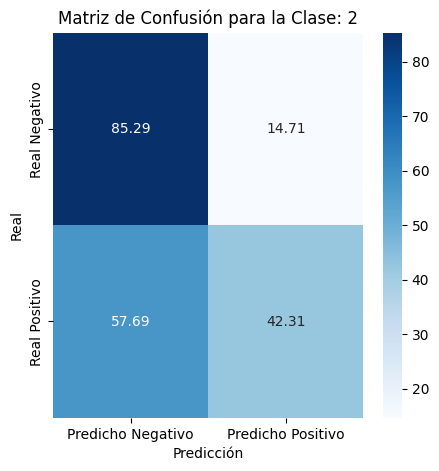

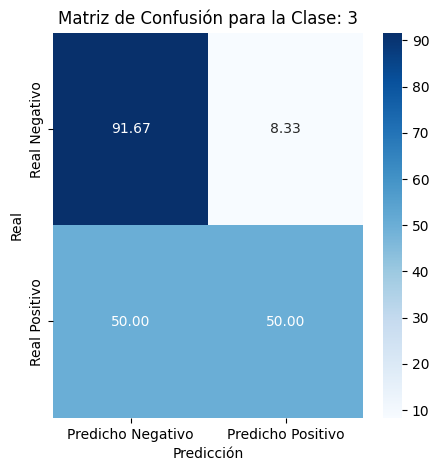

In [19]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import multilabel_confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear una nueva columna transformando la columna 'administracion'
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

# Características y etiquetas
X = df['textos']  # Características
y = df['administracion_multi']  # Usar la nueva columna multiclase

# Convertir texto a características usando TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convertir a matriz 2D

# Codificación de las etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)  # Conversión a formato binario

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)

# Crear los clasificadores
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=100, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=100, random_state=81418)

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('et', et)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)
ovr = OneVsRestClassifier(ensemble_model)

# Entrenar el modelo sin GridSearchCV
ovr.fit(X_train, y_train)

# Predicciones
y_pred = ovr.predict(X_test)

# Evaluación con F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (Macro): {f1:.2f}")

# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calcular Recall para cada clase
recall = recall_score(y_test, y_pred, average=None)  # `average=None` para obtener recall por clase
print(f"Recall por clase: {recall}")

# Obtener la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Normalizar la matriz de confusión para que los valores estén en porcentaje
mcm_percentage = mcm.astype('float') / mcm.sum(axis=2)[:, :, np.newaxis] * 100

# Graficar cada matriz de confusión para cada clase con porcentajes
for i in range(len(mlb.classes_)):
    plt.figure(figsize=(5, 5))
    sns.heatmap(mcm_percentage[i], annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=["Predicho Negativo", "Predicho Positivo"], 
                yticklabels=["Real Negativo", "Real Positivo"])
    plt.title(f"Matriz de Confusión para la Clase: {mlb.classes_[i]}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


### con class_weight='balanced_subsample'

Fitting 3 folds for each of 36 candidates, totalling 108 fits
OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=5,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     random_state=81825))
F1-Score (Macro): 0.56


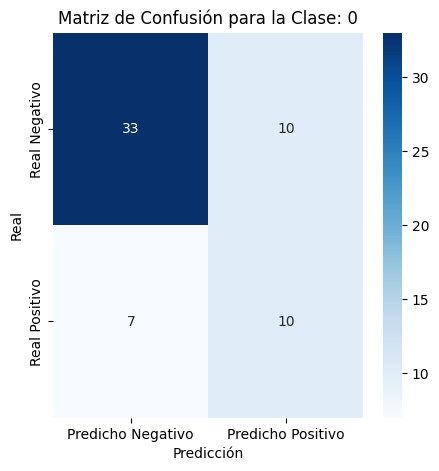

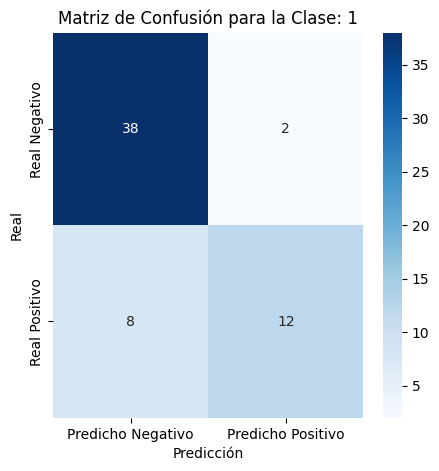

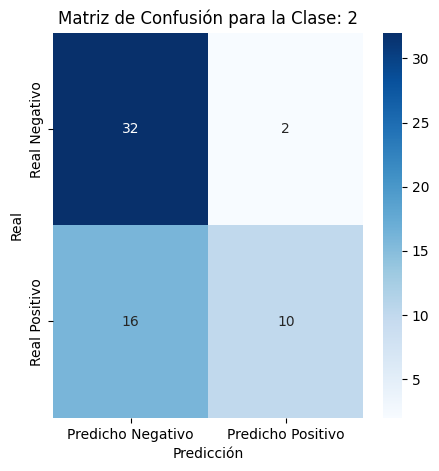

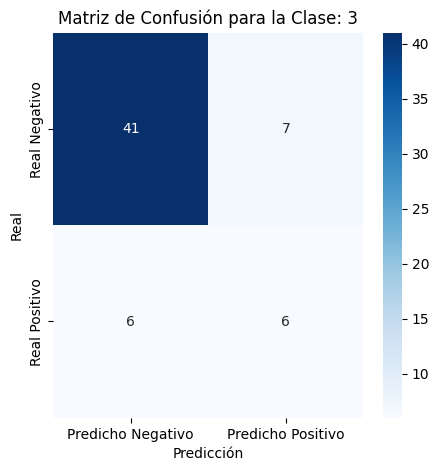

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cargar el DataFrame
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Crear una nueva columna transformando la columna 'administracion'
df['administracion_multi'] = df['administracion'].apply(
    lambda x: [1, 2] if x == 4 else ([2, 3] if x == 5 else [x])
)

# Características y etiquetas
X = df['textos']  # Características
y = df['administracion_multi']  # Usar la nueva columna multiclase

# Convertir texto a características usando TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X).toarray()  # Convertir a matriz 2D

# Codificación de las etiquetas usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)  # Conversión a formato binario

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)

# Crear el clasificador OneVsRest con RandomForestClassifier y ajustar los pesos de las clases
rf = RandomForestClassifier(random_state=81825, class_weight='balanced_subsample')
ovr = OneVsRestClassifier(rf)

# Configurar el GridSearchCV con el clasificador OneVsRest
param_grid = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [5, 10, 15, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=ovr, param_grid=param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_
print(best_rf)

# Predicciones
y_pred = best_rf.predict(X_test)

# Evaluación con F1-Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1-Score (Macro): {f1:.2f}")

# Obtener la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Graficar cada matriz de confusión para cada clase con valores enteros
for i in range(len(mlb.classes_)):
    plt.figure(figsize=(5, 5))
    # Obtener la matriz de confusión para la clase i
    mcm_class = mcm[i]
    # Graficar la matriz de confusión con valores enteros
    sns.heatmap(mcm_class, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicho Negativo", "Predicho Positivo"], 
                yticklabels=["Real Negativo", "Real Positivo"])
    plt.title(f"Matriz de Confusión para la Clase: {mlb.classes_[i]}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


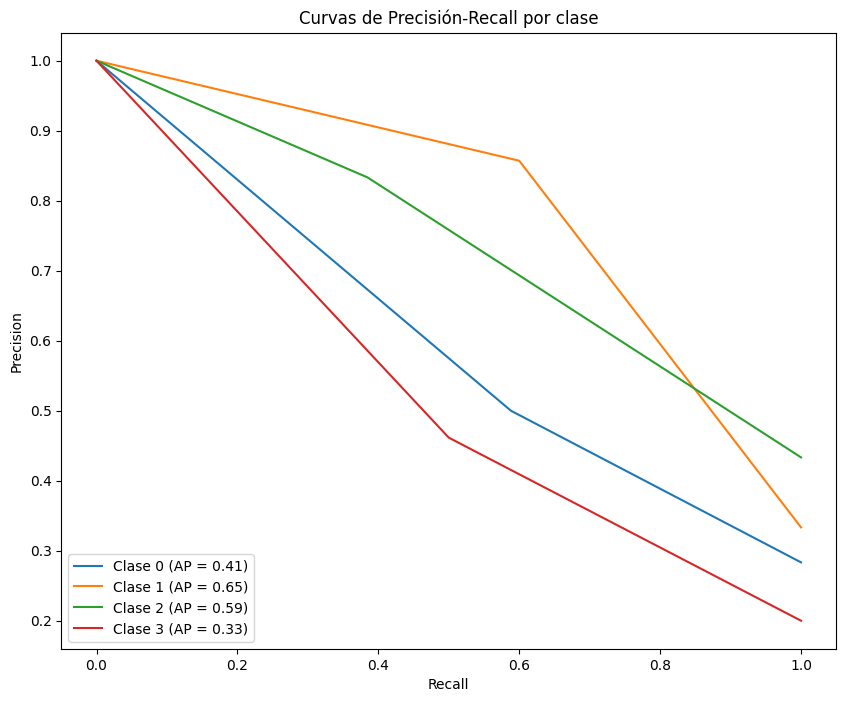

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Curvas de Precisión-Recall por clase
plt.figure(figsize=(10, 8))

for i in range(len(mlb.classes_)):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    
    plt.plot(recall, precision, label=f'Clase {mlb.classes_[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas de Precisión-Recall por clase')
plt.legend(loc='lower left')
plt.show()


# pruebas de subgrupos con dos modelos
hay 6 grupos:

    no linea
    Primera linea
    segunda linea
    tercera linea
    primera y segunda linea 
    segunda o tercera linea
    
Me refiero a clasificar primero de todo el conjunto los primeros 4 metiendo los últimos dos en el grupo de 'no linea' y después ese grupo intentar dividirlo en 'no linea', 'primera y segunda linea' y 'segunda o tercera linea'

*Modelo 2*

Reporte de clasificación para la primera clasificación (conjunto filtrado de 0, 4 y 5):
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           4       0.67      0.50      0.57         4
           5       0.67      0.29      0.40         7

    accuracy                           0.68        22
   macro avg       0.67      0.60      0.60        22
weighted avg       0.68      0.68      0.64        22



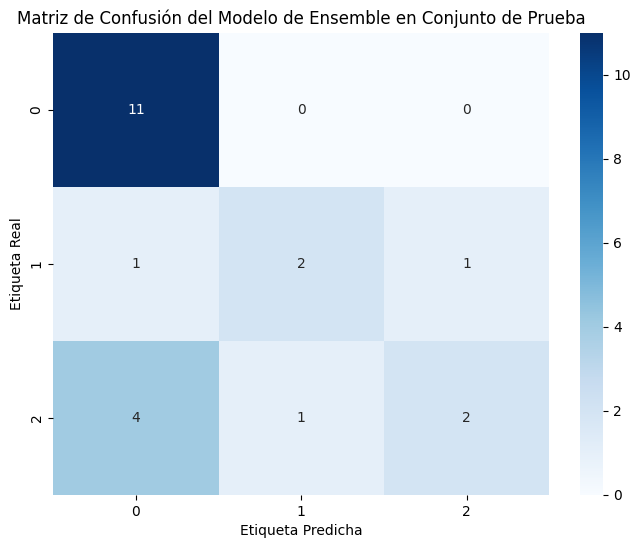

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Filtrar solo los datos con clases 0, 4, y 5
df_filtered = df[df['administracion'].isin([0, 4, 5])]

# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = df_filtered['textos']  # Frases
y = df_filtered['administracion']  # Clases originales

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y, test_size=0.25, random_state=random)

# Vectorización de texto usando TF-IDF
vectorizer2 = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer2.fit_transform(X_train_main)
X_test_tfidf = vectorizer2.transform(X_test_main)

# Crear el modelo de ensemble
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=random)
rf = RandomForestClassifier(n_estimators=100, random_state=random)
et = ExtraTreesClassifier(n_estimators=100, random_state=random)

segundo_ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('et', et),
    ],
    voting='soft'
)

# Entrenar el modelo en el conjunto filtrado de entrenamiento
segundo_ensemble_model.fit(X_train_tfidf, y_train_main)

# Predicciones y evaluación del primer modelo
y_pred_main = segundo_ensemble_model.predict(X_test_tfidf)
print("Reporte de clasificación para la primera clasificación (conjunto filtrado de 0, 4 y 5):")
print(classification_report(y_test_main, y_pred_main))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_main, y_pred_main)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(3)], yticklabels=[str(i) for i in range(3)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

*Modelo 1*

Reporte de clasificación para la primera clasificación:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        22
           1       0.83      0.83      0.83        12
           2       1.00      0.45      0.62        11
           3       0.67      0.40      0.50         5

    accuracy                           0.74        50
   macro avg       0.79      0.65      0.68        50
weighted avg       0.78      0.74      0.73        50



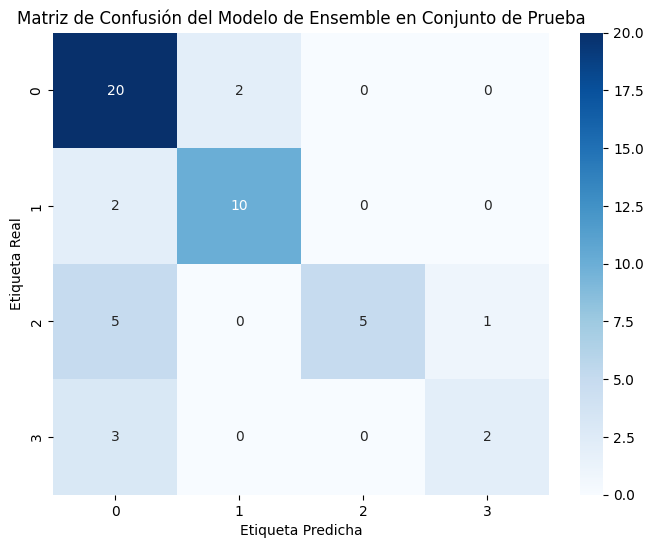

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = df['textos']  # Frases
y = df['administracion']  # Clases originales

# Convertir clases 4 y 5 a 'no linea'
y_main = y.replace({4: 0, 5: 0})  # Cambiar las clases 4 y 5 a 0 ('no linea')

# Dividir los datos en conjuntos de entrenamiento y prueba para la primera clasificación
random = 81418
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y_main, test_size=0.25, random_state=random, stratify=y_main)

# Vectorización de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Puedes ajustar max_features según sea necesario
X_train_tfidf = vectorizer.fit_transform(X_train_main)
X_test_tfidf = vectorizer.transform(X_test_main)

# Crear los clasificadores
gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418)
rf = RandomForestClassifier(n_estimators=150, random_state=81418)
ada = AdaBoostClassifier(random_state=81418)
et = ExtraTreesClassifier(n_estimators=150, random_state=81418)
lr = LogisticRegression(random_state=81418, max_iter=200)

primer_ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('et', et),
        ('lr', lr),
        ('ada', ada)
    ],
    voting='soft'  # 'soft' utiliza las probabilidades, 'hard' usa la mayoría de votos
)

primer_ensemble_model.fit(X_train_tfidf, y_train_main)

# Predicciones y evaluación del primer modelo
y_pred_main = primer_ensemble_model.predict(X_test_tfidf)
print("Reporte de clasificación para la primera clasificación:")
print(classification_report(y_test_main, y_pred_main))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_main, y_pred_main)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(4)], yticklabels=[str(i) for i in range(4)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [52]:
# Filtrar las muestras clasificadas como 'no linea' en el primer modelo
X_no_linea = X_test_main[y_pred_main == 0]
y_no_linea = y[y_test_main.index[y_pred_main == 0]]  # Usamos la clase original para subdividir

In [53]:
X_no_linea_tfidf = vectorizer2.transform(X_no_linea)

In [54]:
# Predicciones y evaluación del segundo modelo
y_pred_sub = segundo_ensemble_model.predict(X_no_linea_tfidf)
print("\nReporte de clasificación para la subdivisión del grupo 'no linea':")
print(classification_report(y_no_linea, y_pred_sub))


Reporte de clasificación para la subdivisión del grupo 'no linea':
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        13
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4

    accuracy                           0.67        30
   macro avg       0.43      0.50      0.45        30
weighted avg       0.48      0.67      0.55        30



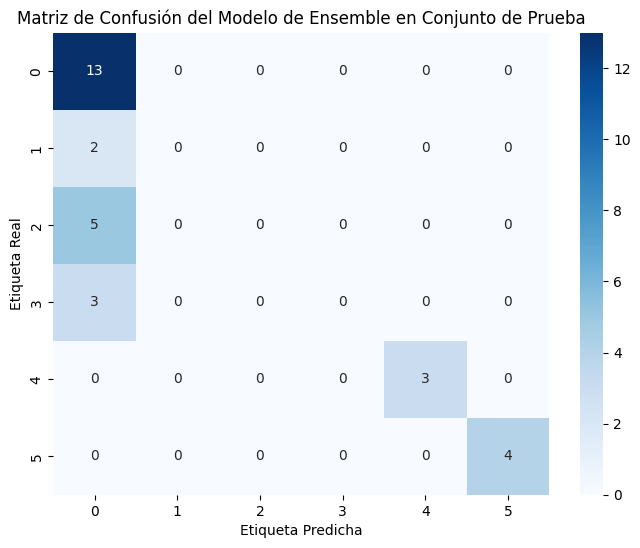

In [55]:

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_no_linea, y_pred_sub)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

*Prueba con la base de datos de test*

Reporte de clasificación para la primera clasificación:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        22
           1       0.83      0.83      0.83        12
           2       1.00      0.45      0.62        11
           3       0.67      0.40      0.50         5

    accuracy                           0.74        50
   macro avg       0.79      0.65      0.68        50
weighted avg       0.78      0.74      0.73        50


Reporte de clasificación para la subdivisión del grupo 'no linea':
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        13
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4

    accuracy                           0.67        30
   macr

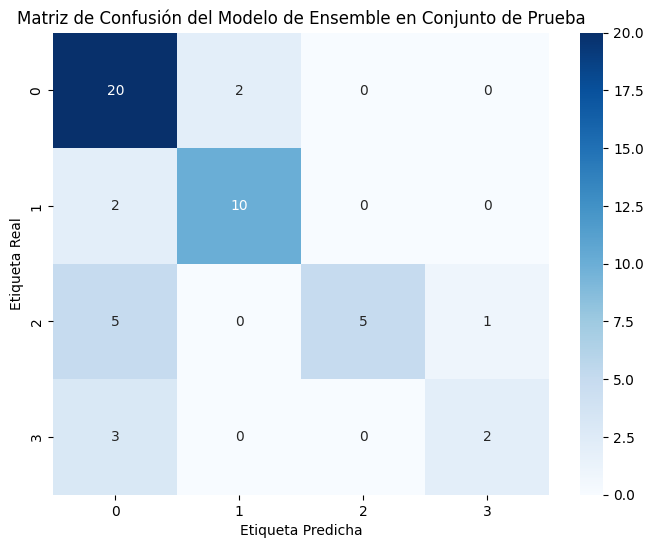

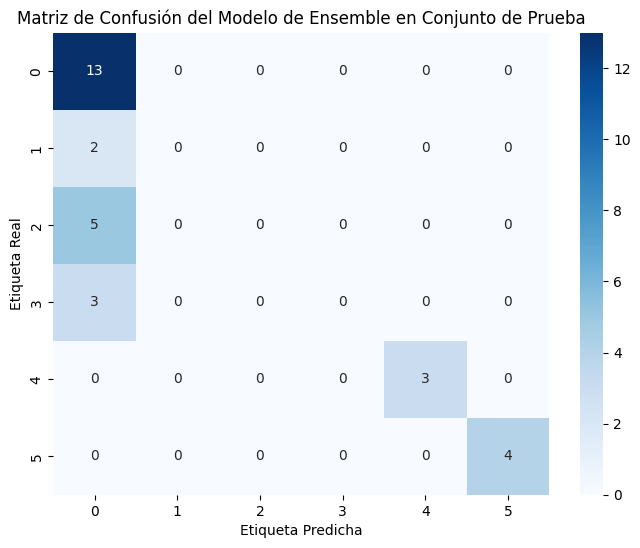

In [57]:
# prueba real

# Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

# Asumimos que 'textos' es la columna de frases y 'administracion' es la columna de clase
X = df['textos']  # Frases
y = df['administracion']  # Clases originales

# Vectorización de texto usando TF-IDF
X_tfidf = vectorizer.transform(X_test_main)

# Predicciones y evaluación del primer modelo
y_pred_main = primer_ensemble_model.predict(X_tfidf)
print("Reporte de clasificación para la primera clasificación:")
print(classification_report(y_test_main, y_pred_main))

# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test_main, y_pred_main)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(4)], yticklabels=[str(i) for i in range(4)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show

# Filtrar las muestras clasificadas como 'no linea' en el primer modelo
X_no_linea = X_test_main[y_pred_main == 0]
y_no_linea = y[y_test_main.index[y_pred_main == 0]]  # Usamos la clase original para subdividir

X_no_linea_tfidf = vectorizer2.transform(X_no_linea)

# Predicciones y evaluación del segundo modelo
y_pred_sub = segundo_ensemble_model.predict(X_no_linea_tfidf)
print("\nReporte de clasificación para la subdivisión del grupo 'no linea':")
print(classification_report(y_no_linea, y_pred_sub))


# Matriz de Confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_no_linea, y_pred_sub)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.title("Matriz de Confusión del Modelo de Ensemble en Conjunto de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [58]:
import pandas as pd

# 1. Crear el DataFrame de casos incorrectamente clasificados en el primer modelo

# Obtener los índices de las instancias de prueba mal clasificadas en el primer modelo
misclassified_mask_main = y_test_main != y_pred_main

# Crear el DataFrame de mal clasificados en el primer modelo
misclassified_df_main = pd.DataFrame({
    'Texto': X_test_main[misclassified_mask_main].values,
    'Etiqueta Real': y_test_main[misclassified_mask_main].values,
    'Etiqueta Predicha': y_pred_main[misclassified_mask_main]
})

# print("\nCasos mal clasificados en el primer modelo:")
# print(misclassified_df_main)

# 2. Crear el DataFrame de casos mal clasificados en el segundo modelo (subconjunto "no línea")

# Filtrar las instancias de "no línea" que fueron mal clasificadas en el segundo modelo
misclassified_mask_sub = y_no_linea != y_pred_sub

# Crear el DataFrame de mal clasificados en el segundo modelo
misclassified_df_sub = pd.DataFrame({
    'Texto': X_no_linea[misclassified_mask_sub].values,
    'Etiqueta Real': y_no_linea[misclassified_mask_sub].values,
    'Etiqueta Predicha': y_pred_sub[misclassified_mask_sub]
})

# print("\nCasos mal clasificados en el segundo modelo (dentro del grupo 'no línea'):")
# print(misclassified_df_sub)

# 3. Concatenar los resultados en un único DataFrame para un análisis general
misclassified_df_total = pd.concat([misclassified_df_main, misclassified_df_sub], ignore_index=True)

print("\nDataFrame completo de casos mal clasificados:")
print(misclassified_df_total)



DataFrame completo de casos mal clasificados:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Texto  \
0                                                                                                                                                                                                                    como monoterapia para el tratamiento de pacientes adultos con cáncer de próstata metastásico 

In [59]:
misclassified_df_total['Longitud Texto'] = misclassified_df_total['Texto'].apply(len)

In [60]:
from IPython.display import display

# Mostrar el DataFrame en una salida interactiva en Jupyter
display(misclassified_df_total)


,Texto,Etiqueta Real,Etiqueta Predicha,Longitud Texto
0,como monoterapia para el tratamiento de pacientes adultos con cáncer de próstata metastásico resistente a la castración (cprc y mutaciones brca1/2 (línea germinal y/o somátic que han progresado tras terapia previa que incluyera un nuevo agente hormonal en combinación con abiraterona y prednisona o prednisolona para el tra tamiento de pacientes adultos con cprcm en los que la quimioterapia no está indicada a juicio del clínico,2,0,431
1,carcinoma hepatocelular (ch lenvima como monoterapia está indicado para el tratamiento de pacientes adultos con carcinoma hepatocelular (ch avanzado o irresecable que no han recibido tratamiento sistémico previo,1,0,212
2,"mastocitosis sistémica avanzada (msa ayvakyt está indicado como monoterapia para el tratamiento de pacientes adultos con mastocitosis sistémica agresiva (ms , mastocitosis sistémica con neoplasia hematológica asociada (ms -nh o leucemia mastocítica (l después de, al menos, un tratamiento sistémico",2,0,299
3,cáncer de mama cáncer de mama her2 -positivo enhertu en monoterapia está indicado para el tratamiento de pacientes adultos con cáncer de mama her2 -positivo no resecable o metastásico que han recibido una o más pautas previas dirigidas a her2 cáncer de mama con baja expresión de her2 enhertu como monoterapia está indicado para el tratamiento de pacientes adultos con cáncer de mama con baja expresión de her2 no resecable o metastásico que han recibido quimioterapia previa en el contexto metastásico o han desarrollado recurrencia de la enfermedad durante o en los 6 meses siguientes a la finalizació n de la quimioterapia adyuvante,2,0,637
4,xtandi está indicado para: tratamiento de hombres adultos con cáncer de próstata resistente a la castración (cpr no metastásico de alto riesgo.,0,1,148
5,"lonsurf está indicado como monoterapia en el tratamiento de pacientes adultos con cáncer colorrectal metastásico que hayan sido previamente tratados o no se les considere candidatos al tratamiento con terapias disponibles, incluidas quimioterapia basada en fluoropirimidinas, oxaliplatino e irinotecán, agentes anti -vegf y agentes anti -egfr cáncer gástrico lonsurf está indicado como monoterapia en el tratamiento de pacientes adultos con cáncer gástrico metastásico incluyendo adenocarcinoma de la unión gastroesofágica, que han sido tratados anteriormente con al menos dos tratamientos sistémicos previos para la enfermedad avanzada",2,3,639
6,"polivy en combinación con rituximab, ciclofosfamida, doxor ubicina, y prednisona (r -ch está indicado para el tratamiento de pacientes adultos con lifoma b difuso de células grandes (lbdc que no han recibido tratamiento previo",1,0,227
7,"encorafenib está indicado: en combinación con binimetinib en adultos para el tratamiento del melanoma no resecable o metastásico con mutación braf v600 (ver las secciones 4. 4 y 5. en combinación con cetuximab, par a el tratamiento de pacientes adultos con cáncer colorrectal metastásico (ccr con mutación braf v600e, que han recibido terapia sistémica previa",2,0,361
8,Utilizado como una de las últimas alternativas terapéuticas.,3,0,60
9,"en comparación con nivolumab en monoterapia se ha establecido un aumento de la supervivencia libre de progresión (sl y supervivencia global (s para la combinación de nivolumab con ipilimumab, solamente en los pacientes con baja expresión de pd -l1 en el tumor tratamiento adyuvante del melanoma opdivo en monoterapia está indicado para el tratamiento adyuvante en adultos y adolescentes a partir de 12 años con melanoma en estadio iib o iic o melanoma con afectación de los ganglios linfáticos o enfermedad metastásica que hayan sido sometidos a resección completa",2,0,566
